In [1]:
#!/usr/bin/env python3
import tensorflow as tf

import os
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator

from src.ForecastModel.utils.metrics import (calculate_nse, calculate_kge, calculate_bias, load_metrics,
                                             calculate_bias_flv, calculate_bias_fhv,
                                            )
from src.ForecastModel.utils.postprocessing import ModelHandler

import numpy as np
import pandas as pd

plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 6,
})

In [2]:
PLOT_PATH = r"hess_paper_output"
DATA_PATH = r"src\data\Dataset.csv"

In [3]:
models = {
    "arima": ModelHandler("ARIMA",
                r"models\ARIMA",
                is_final_model = True,
                is_external_model = True,
                color = "#ff7f00",
                ls = "-",
                  ),
     "elstm": ModelHandler("eLSTM",
                   r"models\eLSTM",
                   is_final_model = True,
                   color = '#984ea3',
                   ls = "-",
                 ),
     "pbhm-hlstm": ModelHandler("PBHM-HLSTM",
               r"models\PBHM-HLSTM",
               is_final_model = True,
               color = "#e41a1c",
               ls = "-",
              )
     }

In [4]:
# calculate metrics of hydrologic model per fold
dfh = pd.read_csv(DATA_PATH, parse_dates=['time'])

hyd_metrics = {}
for year in range(2012, 2018):
      dfp = dfh.loc[dfh["time"].dt.year == year]
      hyd_metrics[year] = {
          "kge":  calculate_kge(dfp.qmeasval.values, dfp.qsim.values),
          "nse":  calculate_nse(dfp.qmeasval.values, dfp.qsim.values),
          "bias": calculate_bias(dfp.qmeasval.values, dfp.qsim.values),
          "fhv": calculate_bias_fhv(dfp.qmeasval.values, dfp.qsim.values),
          "flv": calculate_bias_flv(dfp.qmeasval.values, dfp.qsim.values),
      }    
    

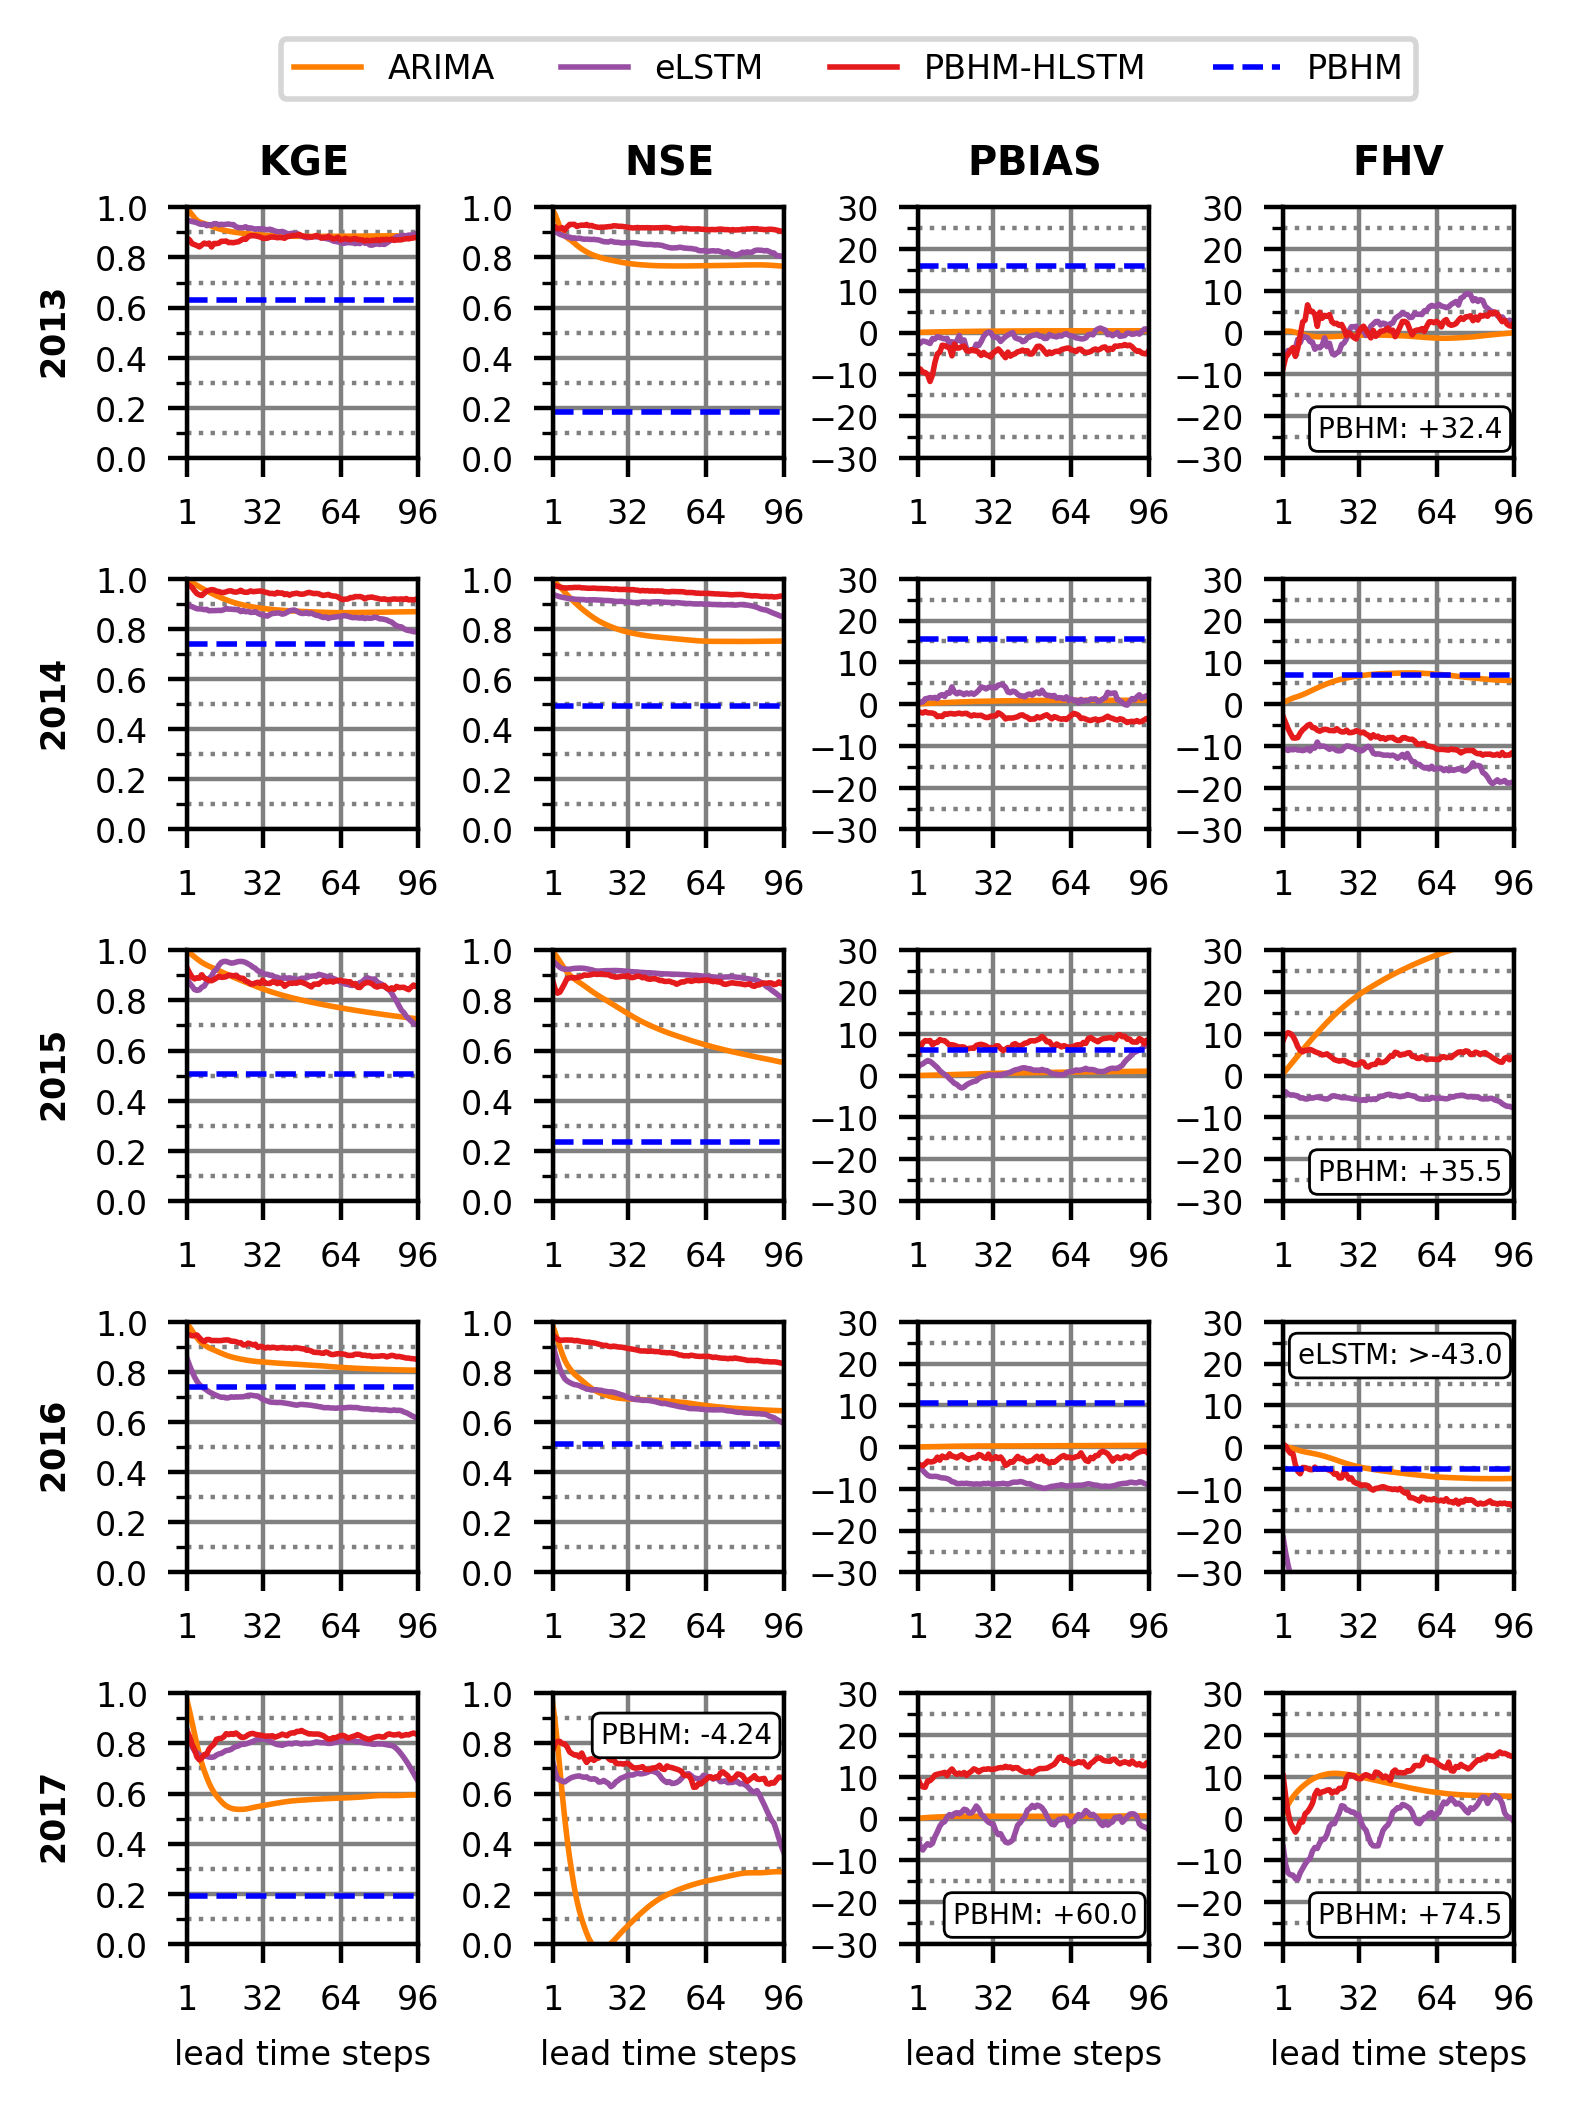

In [5]:
fig, axes = plt.subplots(5,4,figsize=(4.72,5), dpi=400)

metric_names = ["kge", "nse", "bias", "fhv"]
metric_labels = ["KGE", "NSE", "PBIAS", "FHV"]
ylims = [(0,1), (-2,1)]


xx = np.arange(1,97)
df = pd.DataFrame(columns=["name", "year", 
                           "kge_min", "kge_avg", "kge_max", 
                           "nse_min", "nse_avg", "nse_max", 
                          ])

n_row = -5
for n, key in enumerate(models.keys()):
    metrics = load_metrics(os.path.join(models[key].lg_path, "metrics_eval.txt"))
    
    n_row += 5
    for j, met in enumerate(metric_names):
        metric  = metrics["test"][met]
        for i in range(5):
            df.loc[n_row+i, ["name", "year"]] = [models[key].name, 2013+i]
            df.loc[n_row+i, [f"{met}_min", f"{met}_avg", f"{met}_max"]] = [np.min(metric[i]), 
                                                                           np.mean(metric[i]), 
                                                                           np.max(metric[i])]
            df.loc[n_row+i, [f"{met}_{x}" for x in range(96)]] = [metric[i][x] for x in range(96)]
            xx = np.arange(1,np.array(metric[i]).shape[0]+1)
            axes[i,j].plot(xx, metric[i], color=models[key].color, ls=models[key].ls, label=f"{models[key].name}", lw=1)


for i in range(5):
    for j, met in enumerate(metric_names):
        if i == 0:
            axes[i,j].set_title(r"$\bf{"+f"{metric_labels[j]}"+r"}$")
        elif i == 4:
            axes[i,j].set_xlabel("lead time steps")
        if j == 0:
            axes[i,j].set_ylabel(r"$\bf{"+f"{2013 + i}"+r"}$")

        axes[i,j].hlines(hyd_metrics[2013+i][metric_names[j]], 1, 96, color="b", ls = "--", label="PBHM", lw=1)
        if (i == 4) & (j == 1):
            metric_hyd = hyd_metrics[2013+i][metric_names[j]]
            axes[i,j].text(91,0.8, f"PBHM: {metric_hyd:+4.2f}", color="k", ha="right", fontsize=5,
                     bbox={"boxstyle": "round",
                               "ec":(0, 0, 0),
                               "fc":(1., 1, 1),
                               "lw": 0.5,
                     })
        if (i == 4) & (j == 2):
            metric_hyd = hyd_metrics[2013+i][metric_names[j]]
            axes[i,j].text(91,-25, f"PBHM: {metric_hyd:+4.1f}", color="k", ha="right", fontsize=5,
                     bbox={"boxstyle": "round",
                               "ec":(0, 0, 0),
                               "fc":(1., 1, 1),
                               "lw": 0.5,
                     })
        
        if (i in [0, 2, 4]) & (j == 3):
            metric_hyd = hyd_metrics[2013+i][metric_names[j]]
            axes[i,j].text(91,-25, f"PBHM: {metric_hyd:+4.1f}", color="k", ha="right", fontsize=5,
                     bbox={"boxstyle": "round",
                               "ec":(0, 0, 0),
                               "fc":(1., 1, 1),
                               "lw": 0.5,
                     })

        if (i == 3) & (j == 3):
            metric = df.loc[df.name=="eLSTM"].filter(regex="fhv_[0-9]").min(axis=1).values[3] # get value from df
            axes[i,j].text(91,20, f"eLSTM: >{metric:+4.1f}", color="k", ha="right", fontsize=5,
                     bbox={"boxstyle": "round",
                               "ec":(0, 0, 0),
                               "fc":(1., 1, 1),
                               "lw": 0.5,
                     })
            
            
            
        axes[i,j].set_xticks([1,32,64,96])
        if j in [2, 3]:
            axes[i,j].yaxis.set_major_locator(MultipleLocator(10))
            axes[i,j].yaxis.set_minor_locator(MultipleLocator(5))
            axes[i,j].set_ylim((-30,30))
        else:
            axes[i,j].yaxis.set_major_locator(MultipleLocator(0.2))
            axes[i,j].yaxis.set_minor_locator(MultipleLocator(0.1))
            axes[i,j].set_ylim((0,1))

        axes[i,j].set_xlim((1,96))
        
        axes[i,j].grid(which='major', color='grey', linestyle='-')
        axes[i,j].grid(which='minor', color='grey', linestyle=':')


fig.tight_layout()
plt.subplots_adjust(right = 0.8)
axes[0,2].legend(bbox_to_anchor=(-0.3, 1.3), 
                 loc='lower center', ncol=4, 
                 borderaxespad=1)


In [6]:
# save figure
fig.savefig(os.path.join(PLOT_PATH, 'fig5_leadtime_performance.png'), bbox_inches="tight", dpi=300)

In [7]:
# contains all lead time steps
df_res = df.set_index(pd.MultiIndex.from_arrays([df.name, df.year], names=['model', 'fold'])).drop(["name", "year"], axis=1)

# only show summary
df_res.filter(regex="[a-z]_[a-z]")

kge_min   kge_avg   kge_max   nse_min   nse_avg   nse_max  \
model      fold                                                               
ARIMA      2013  0.883965  0.896109  0.992364  0.765174  0.790791  0.991315   
           2014  0.865033  0.887936  0.995619   0.75018  0.794716   0.99437   
           2015  0.726017  0.820014  0.995044  0.551945  0.702966  0.994329   
           2016   0.80667  0.840894  0.992716  0.644688  0.701259   0.98698   
           2017  0.536915  0.596397  0.968628 -0.018164  0.221863  0.965589   
eLSTM      2013  0.849049  0.894369  0.947633  0.802678  0.845648  0.911951   
           2014  0.787249  0.853864  0.900123   0.84717  0.902426  0.939621   
           2015  0.704111  0.877162  0.955778  0.810921  0.901531  0.959337   
           2016  0.614212  0.679236  0.851625  0.594231  0.684377  0.908311   
           2017  0.647341  0.786206  0.850612  0.365707  0.638627  0.727888   
PBHM-HLSTM 2013  0.842012  0.872642  0.892263  0.902632  0.917097   0.93204   
           2014  0.915313  0.936866  0.979177  0.927423  0.948828  0.975328   
           2015  0.842823  0.872221  0.928476  0.828856  0.879598  0.906373   
           2016  0.850567  0.890864  0.949798  0.834203  0.879677  0.949695   
           2017  0.734114  0.825046  0.851735  0.624776  0.699873  0.808017   

                  bias_min   bias_avg   bias_max    fhv_min    fhv_avg  \
model      fold                                                          
ARIMA      2013   0.038485   0.363652   0.444583  -1.344978  -0.740518   
           2014   0.038939   0.740840   0.924147   0.344575   5.848753   
           2015   0.020277   0.644422   1.064523   0.564424  22.432406   
           2016   0.023539   0.294308   0.432629  -7.561154  -5.240327   
           2017   0.060921   0.536473   0.662107   1.193207   7.433505   
eLSTM      2013  -4.339852  -1.084802   1.100470  -5.643594   2.282588   
           2014  -0.239302   2.061313   4.661750 -19.048086 -13.400710   
           2015  -2.949873   1.307625   7.126348  -7.830905  -5.351197   
           2016  -9.900908  -8.587589  -3.772399 -42.981597 -38.592706   
           2017  -7.522888  -0.722015   3.219638 -14.527836  -0.968033   
PBHM-HLSTM 2013 -11.691428  -4.692457  -2.738579  -8.402898   1.528907   
           2014  -4.409743  -3.064232  -1.698592 -12.310510  -8.780888   
           2015   5.118519   7.738321   9.806168   2.049011   4.726929   
           2016  -4.473625  -2.603551  -0.928316 -14.407728  -9.777600   
           2017   7.502804  12.163268  14.717694  -3.241150  10.099909   

                   fhv_max  
model      fold             
ARIMA      2013   0.364866  
           2014   7.465016  
           2015  34.700103  
           2016   0.025213  
           2017  10.834870  
eLSTM      2013   9.345605  
           2014  -9.083376  
           2015  -3.703567  
           2016 -21.777544  
           2017   5.573245  
PBHM-HLSTM 2013   6.647076  
           2014  -3.047553  
           2015  10.276027  
           2016   0.664191  
           2017  15.965672

In [8]:
# find minimum NSE/KGE over all folds
df_res.filter(regex="e_[a-z]").groupby("model").min()

,kge_min,kge_avg,kge_max,nse_min,nse_avg,nse_max
model,,,,,,
ARIMA,0.536915,0.596397,0.968628,-0.018164,0.221863,0.965589
PBHM-HLSTM,0.734114,0.825046,0.851735,0.624776,0.699873,0.808017
eLSTM,0.614212,0.679236,0.850612,0.365707,0.638627,0.727888


In [9]:
# find absolut maximum biases over all folds
df_res.abs().filter(regex="[^e]_[a-z]").groupby("model").max()

,bias_min,bias_avg,bias_max,fhv_min,fhv_avg,fhv_max
model,,,,,,
ARIMA,0.060921,0.740840,1.064523,7.561154,22.432406,34.700103
PBHM-HLSTM,11.691428,12.163268,14.717694,14.407728,10.099909,15.965672
eLSTM,9.900908,8.587589,7.126348,42.981597,38.592706,21.777544


# compares terms of kge metric as average over all folds

In [21]:
df_kge = pd.DataFrame(columns=["name", "year", 
                               "kge_term_var", "std_kge_term_var", 
                               "kge_term_bias", "std_kge_term_bias", 
                               "kge_term_linear", "std_kge_term_linear"])

n_row = -5
for n, key in enumerate(models.keys()):
    metrics = load_metrics(os.path.join(models[key].lg_path, "metrics_eval.txt"))
    
    n_row += 5
    for j, met in enumerate(["kge_term_var", "kge_term_bias", "kge_term_linear"]):
        metric  = metrics["test"][met]
        for i in range(5):
            df_kge.loc[n_row+i, ["name", "year"]] = [models[key].name, 2013+i]
            df_kge.loc[n_row+i, [met, "std_"+met]] = [np.mean(metric[i])-1, np.std(metric[i])]

df_kge.groupby("name").mean().drop("year", axis=1)

,kge_term_var,std_kge_term_var,kge_term_bias,std_kge_term_bias,kge_term_linear,std_kge_term_linear
name,,,,,,
ARIMA,0.03053,0.039825,0.005159,0.001705,-0.171668,0.041782
PBHM-HLSTM,-0.035028,0.026049,0.019083,0.011035,-0.051597,0.007366
eLSTM,-0.105987,0.038551,-0.014051,0.015634,-0.099624,0.018183
